# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in `pierce_county_house_sales.csv`, car prices in `cars_hw.csv`, and airbnb rental prices in `airbnb_hw.csv`.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an 80/20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. Use the `sklearn.linear_model.Lasso` to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

Raw shape: (30478, 13)
    Host Id Host Since                             Name Neighbourhood   \
0   5162530        NaN  1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN  Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN             Sunny Room in Harlem      Manhattan   

  Property Type  Review Scores Rating (bin)        Room Type  Zipcode  Beds  \
0     Apartment                         NaN  Entire home/apt  11249.0   1.0   
1     Apartment                         NaN     Private room  11206.0   1.0   
2     Apartment                         NaN     Private room  10032.0   1.0   

   Number of Records  Number Of Reviews Price  Review Scores Rating  
0                  1                  0   145                   NaN  
1                  1                  1    37                   NaN  
2                  1                  1    28                   NaN  
Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       '

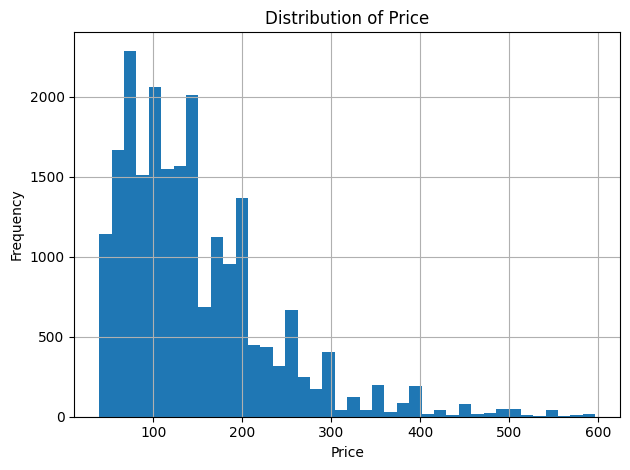

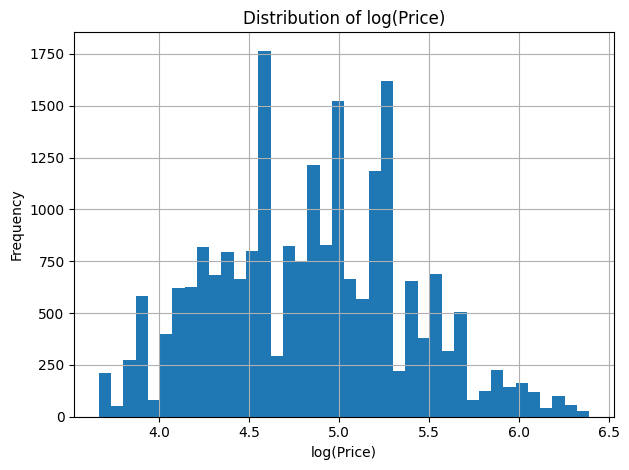

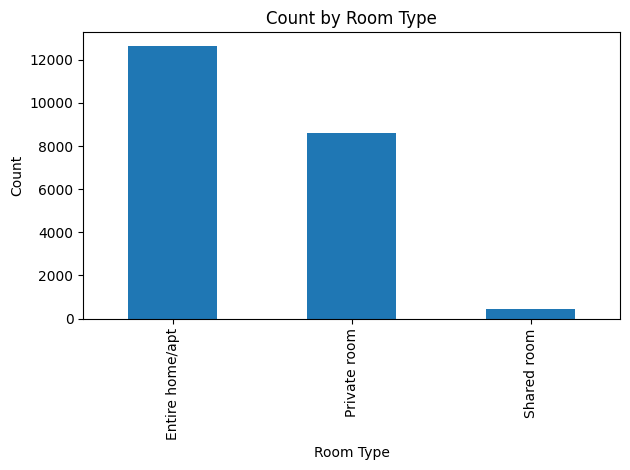

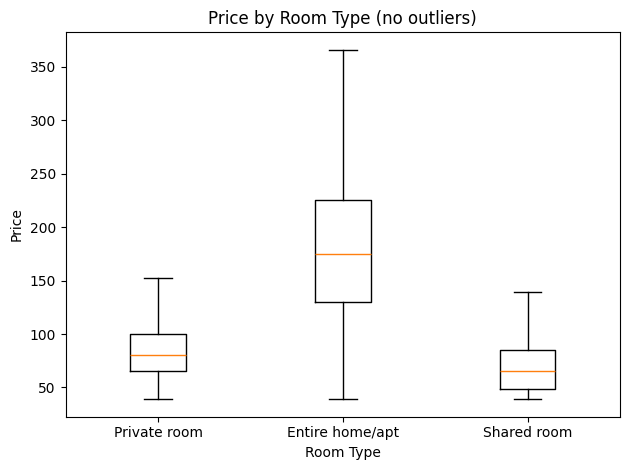

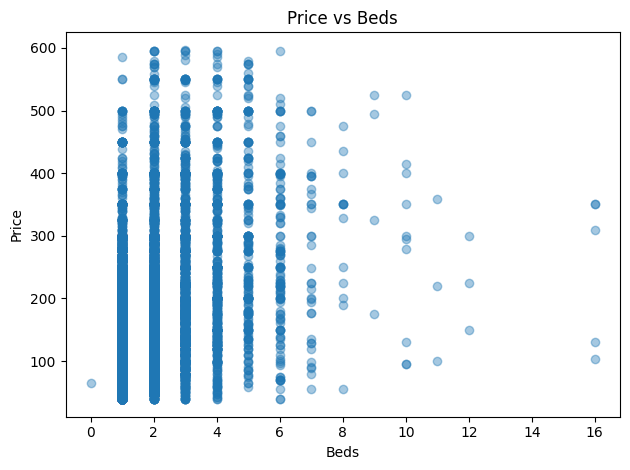

Saved cleaned file to /mnt/data/airbnb_clean.csv


In [6]:
#1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/airbnb_hw.csv')
print("Raw shape:", df.shape)
print(df.head(3))       # peek
print(df.columns)       # see exact column names

# Keep the columns we care about
needed = [
    'Price',
    'Beds',
    'Room Type',
    'Property Type',
    'Neighbourhood ',
    'Number Of Reviews',
    'Review Scores Rating'
]


# Basic Cleaning
# Price might be a string with symbols -> make it numeric
df['Price'] = (
    df['Price'].astype(str)
               .str.replace(r'[^0-9\.]', '', regex=True)
               .replace('', np.nan)
               .astype(float)
)

# Make numeric columns numeric (change errors to NaN)
df['Beds'] = pd.to_numeric(df['Beds'], errors='coerce')
df['Number Of Reviews'] = pd.to_numeric(df['Number Of Reviews'], errors='coerce')
df['Review Scores Rating'] = pd.to_numeric(df['Review Scores Rating'], errors='coerce')

# Drop rows with ANY missing in the needed columns
df_clean = df.dropna(subset=needed).copy()

# Keep only positive prices
df_clean = df_clean[df_clean['Price'] > 0]

# Trim extreme outliers (1st–99th percentiles) to make plots/models nicer
p1, p99 = df_clean['Price'].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean['Price'] >= p1) & (df_clean['Price'] <= p99)]

# Feature engineering: log price
df_clean['log_price'] = np.log(df_clean['Price'])

print("Clean shape:", df_clean.shape)

# Quick summaries
print("\n=== Numeric summary ===")
print(df_clean[['Price','log_price','Beds','Number Of Reviews','Review Scores Rating']].describe())

print("\n=== Counts by Room Type ===")
print(df_clean['Room Type'].value_counts())

print("\n=== Mean Price by Neighbourhood ===")
print(df_clean.groupby('Neighbourhood ')['Price'].mean().sort_values(ascending=False))

# Histogram of Price
plt.figure()
df_clean['Price'].hist(bins=40)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram of log(Price)
plt.figure()
df_clean['log_price'].hist(bins=40)
plt.title('Distribution of log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Bar: counts by Room Type
plt.figure()
df_clean['Room Type'].value_counts().plot(kind='bar')
plt.title('Count by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot: Price by Room Type (hide outliers so scale is readable)
plt.figure()
groups = [df_clean.loc[df_clean['Room Type'] == rt, 'Price'] for rt in df_clean['Room Type'].unique()]
labels = list(df_clean['Room Type'].unique())
plt.boxplot(groups, tick_labels=labels, showfliers=False)
plt.title('Price by Room Type (no outliers)')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Scatter: Price vs Beds
plt.figure()
plt.scatter(df_clean['Beds'], df_clean['Price'], alpha=0.4)
plt.title('Price vs Beds')
plt.xlabel('Beds')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Save cleaned data
df_clean.to_csv('/content/airbnb_clean.csv', index=False)
print("Saved cleaned file to /mnt/data/airbnb_clean.csv")

We chose to use the airbnb rental prices data set.

In this data set, the price distribution is heavily right-skewed. Most Airbnb listings cost between 50 and 200 dollars per night, but there are a few very expensive listings that pull the distribution to the right.

After applying the log transformation, the price distribution becomes much more symmetric. This makes it a better variable for regression because it reduces the influence of extreme outliers.

Entire homes/apartments make up the largest share of listings, followed by private rooms. Shared rooms are much less common in this dataset.

Entire homes/apartments are generally much more expensive than private or shared rooms. Private rooms tend to be moderately priced, and shared rooms are usually the cheapest option.

There is a positive relationship between the number of beds and price. Listings with more beds usually cost more. However, the relationship is not perfectly linear and there is a lot of variation even among listings with the same number of beds.

In [8]:
#2
#Transform Variables for Regression

# Columns we want to keep for the hedonic model
model_cols = [
    'log_price',           # target variable
    'Beds',
    'Number Of Reviews',
    'Review Scores Rating',
    'Room Type',
    'Property Type',
    'Neighbourhood '
]

# Keep only those columns
df_model = df_clean[model_cols].copy()

# Convert categorical variables to dummy variables (one-hot encoding)
categorical = ['Room Type', 'Property Type', 'Neighbourhood '] # Corrected column name

df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True)

print("Shape after dummy encoding:", df_model.shape)
df_model.head()

Shape after dummy encoding: (21696, 27)


,log_price,Beds,Number Of Reviews,Review Scores Rating,Room Type_Private room,Room Type_Shared room,Property Type_Bed & Breakfast,Property Type_Boat,Property Type_Bungalow,Property Type_Cabin,...,Property Type_Lighthouse,Property Type_Loft,Property Type_Other,Property Type_Townhouse,Property Type_Treehouse,Property Type_Villa,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island
4,6.308098,3.0,39,96.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,5.003946,1.0,4,100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,5.521461,1.0,9,100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7,4.499810,1.0,80,94.0,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,5.598422,2.0,95,90.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


This table shows the cleaned and transformed dataset that we will use for our hedonic pricing model. The target variable is log_price, which is the natural log of the listing’s nightly price. All the predictor variables are numeric now. For example, Beds, Number Of Reviews, and Review Scores Rating are continuous variables.

The categorical variables such as room type, property type, and neighborhood were converted into dummy variables (True/False columns). Each dummy variable represents whether or not a listing belongs to that specific category.

This transformation allows us to use these features in a regression model since machine learning algorithms require numeric inputs. The dataset now contains 27 columns, with one target and 26 features that can help predict the price of an Airbnb listing.

In [9]:
#3
from sklearn.model_selection import train_test_split

# Target variable (what we want to predict)
y = df_model['log_price']

# Features (everything else)
X = df_model.drop(columns=['log_price'])

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,     # 20% test set
    random_state=123,   # makes it reproducible
)

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (17356, 26)
Test features shape: (4340, 26)
Training target shape: (17356,)
Test target shape: (4340,)
